In [1]:
import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
import mdn
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 44100
overlap = 2756

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio(fld, data, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    target = []
    for i, sample in f_df.iterrows():
        if debug: print("File Processing", end="", flush=True)
        y, sr = librosa.load(audio_dir + sample['filename'], sr=SR, mono=True)
        len_second = 5.0
        if debug: print(".", end="", flush=True)
        y = y[:int(sr*len_second)]
        y = y[np.newaxis, :]
        if debug: print(".", end="", flush=True)
        items.append(y)
        target.append(sample.target)
        if debug: print("Done")
            

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.array(items), np.array(target)

def load_all_audio(data):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        y, sr = librosa.load(audio_dir + sample['filename'], sr=SR, mono=True)
        len_second = 5.0
        y = y[:int(sr*len_second)]
        y = y[np.newaxis, :]
        items.append(y)
        target.append(sample.target)
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.array(items), np.array(target)

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 5.711413383483887
(2166, 1, 44100)


# MFCC Visualizer

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
static_stft (Spectrogram) (None, 513, 690, 1)       1050624     
________________________________________________________________________________
mel_bank (Filterbank)     (None, 100, 690, 1)       51300       
Total params: 1,101,924
Trainable params: 0
Non-trainable params: 1,101,924
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 1s 354ms/step - loss: 1.8674
(1, 44100)


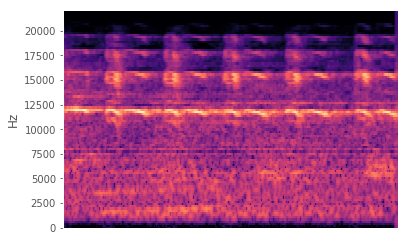

(2166, 100, 690)


In [13]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Spectrogram(n_dft=1024, n_hop=64, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=False, name='static_stft'))
model.add(Filterbank(n_fbs=100, trainable_fb=False, sr=SR, init='mel', fmin=0, fmax=SR//2, bins_per_octave=12,
                    name='mel_bank'))
check_model(model)
# for src in c_data:
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

In [14]:
frames = mfccs

In [15]:
# Divide audio samples into dilated spectral buffers
def make_dilated_spectral_frames(spectrogram,
                                 num_frames, 
                                 dilation_factor):
    dilated_frames = np.zeros((len(spectrogram), 
                              num_frames, 
                              len(spectrogram[0])))

    for i in range(len(spectrogram)):
        for j in range(num_frames):
            dilation = np.power(dilation_factor, j)

            if i - dilation < 0:
                dilated_frames[i][j] = spectrogram[0]
            else:
                dilated_frames[i][j] = spectrogram[i - dilation]

    return dilated_frames

In [16]:
frames = []
for frame in mfccs:
    frames.append(make_dilated_spectral_frames(frame, 42, 4))

KeyboardInterrupt: 

In [ ]:
frames = np.vstack(frames)
print(frames.shape)

In [ ]:
display.specshow(frames[6], y_axis='linear', sr=SR)
plt.show()

In [ ]:
# frames = np.expand_dims(frames, axis=3)
# frames.shape

## Autoencoder

In [ ]:
from keras.models import Model
from keras.layers import MaxPooling2D, UpSampling2D, InputLayer, RepeatVector, Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, Input

def build_pca_autoencoder(img_shape,code_size=32, optimizer_type='adadelta', loss_type='mse'):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential(name='encoder')
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())                  #flatten image to vector
    encoder.add(Dense(code_size*8, activation='relu'))
    encoder.add(Dense(code_size*4, activation='tanh'))
    encoder.add(Dense(code_size*2, activation='tanh'))
    encoder.add(Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential(name='decoder')
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(code_size*2, activation='tanh'))
    decoder.add(Dense(code_size*4, activation='tanh'))
    decoder.add(Dense(code_size*8, activation='relu'))
    decoder.add(Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(Reshape(img_shape))         #un-flatten
    
    decoder.compile(optimizer=optimizer_type,
                        loss = loss_type,
                        metrics=['acc'])
    
    inp = Input(img_shape)
    code = encoder(inp)
    reconstruction = decoder(code)
    
    autoencoder = Model(inp, reconstruction)
    autoencoder.compile(optimizer_type, loss_type, metrics=['acc'])
    
    autoencoder.summary()
    
    return autoencoder

def build_deep_conv_autoencoder(img_shape=None, output_shape=None, optimizer_type='adadelta', loss_type='binary_crossentropy'):
    n_hidden_1 = 32  # 1st hidden layer
    n_hidden_2 = 16  # 2nd hidden layer
    n_hidden_3 = 8  # 3rd hidden layer

    convkernel = (3, 3)  # convolution (uses filters): n_filters_1 -> n_filters_2
    poolkernel = (2, 2)  # pooling (down/up samples image): ypix -> ypix/ypoolkernel, xpix -> xpix/ypoolkernel

    ### Encoding hidden layers ###
    input_img = Input(shape=input_shape)  # input layer (ypixels, xpixels, n_channels)
    x = Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(input_img)
    x = MaxPooling2D(poolkernel, padding='same')(x)
    x = Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
    x = MaxPooling2D(poolkernel, padding='same')(x)
    x = Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
    encoded = MaxPooling2D(poolkernel, padding='same', name='encoder')(x)  # encoding layer

    ### Decoding hidden layers ###
    x = Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(encoded)
    x = UpSampling2D(poolkernel)(x)
    x = Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
    x = UpSampling2D(poolkernel)(x)
    x = Conv2D(n_hidden_1, convkernel, activation='relu')(x)
    x = UpSampling2D(poolkernel)(x)
    decoded = Conv2D(output_shape[2], convkernel, activation='sigmoid', padding='same')(x) # output layer
    
    autoencoder = Model(input_img, decoded)
    
    autoencoder.compile(optimizer_type, loss_type, metrics=['acc'])
    
    autoencoder.summary()
    
    return autoencoder

In [ ]:
from keras.models import model_from_json
try:
    print("Loading Previously Trained Model")
    json_file = open('autoencoder_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    auto = model_from_json(loaded_model_json)
    auto.load_weights('autoencoder_weights.hd5')
    auto.compile(optimizer='adam', loss='mse')
    auto.summary()
except:
    print("Couldn't find model, training new one")
    auto = build_pca_autoencoder(img_shape=frames[0].shape, code_size=64)
    auto.fit(x=frames, y=frames, epochs=10, shuffle=True, verbose=1)
    model_json = auto.to_json()
    with open('autoencoder_model.json', 'w') as json_file:
        json_file.write(model_json)
    auto.save_weights('autoencoder_weights.hd5')

In [ ]:
result = auto.predict(frames, verbose=1)
print(result.shape)

In [ ]:
display.specshow(np.squeeze(result[100]), y_axis='linear', sr=SR)
plt.show()
display.specshow(np.squeeze(frames[100]), y_axis='linear', sr=SR)
plt.show()

# Encode

In [ ]:
enc = keras.models.Sequential(name='encoder')
enc.add(InputLayer((8,100)))
enc.add(auto.get_layer('encoder'))
dta = enc.predict(frames, verbose=1)
print(dta.shape)

In [ ]:
print(n_targets.shape)

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        dta, n_targets, test_size=0.20, random_state=42)

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animal vs interacting objects)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

dropout = 0.25

epochs = 20
batch = 128

latent_dim = 32

src = np.random.random((1, blocksize))

def gpu_mfcc_shallow_net():
    # Create Model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(19, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(31, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [ ]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

In [ ]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

In [ ]:
dta_a = dta[n_targets == 0]
targ_a = cat_targets[n_targets == 0]
dta_i = dta[n_targets == 1]
targ_i = cat_targets[n_targets == 1]

In [ ]:
names_a = []
for name in np.unique(targ_a):
    names_a.append(classes[name])
names_i = []
for name in np.unique(targ_i):
    names_i.append(classes[name])
print(names_a)
print(names_i)

In [ ]:
print(targ_a.shape)
print(targ_i.shape)
print(cat_targets.shape)
print()
print(dta_a.shape)
print(dta_i.shape)
print(dta.shape)

## Animal Sounds

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
                        dta_a, targ_a, test_size=0.20, random_state=56)

In [ ]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, epochs=epochs, batch_size=batch, validation_split=0.15)
history = anim.fit(train_X, train_y)

In [ ]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

## Interacting Materials

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
                        dta_i, targ_i, test_size=0.20, random_state=75)

In [ ]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

In [ ]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [ ]:
X2, y2, y22 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, y33 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, y44 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, y55 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

In [ ]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

In [ ]:
y = np.concatenate((y2, y3, y4, y5))
yy = np.concatenate((y22, y33, y44, y55))
print(y.shape)
print(yy.shape)

In [ ]:
testing_mfccs = evaluate_model(model, X)
print(testing_mfccs.shape)
test_frames = []
for frame in testing_mfccs:
    test_frames.append(make_dilated_spectral_frames(frame, 8, 2))
test_frames = np.vstack(test_frames)
print(test_frames.shape)
test_dta = enc.predict(test_frames ,verbose=1)
print(test_dta.shape)

In [ ]:
testing_n_targets = np.repeat(y, testing_mfccs.shape[1])
testing_cat_targets = np.repeat(yy, testing_mfccs.shape[1])
print(testing_n_targets.shape)
print(testing_cat_targets.shape)

In [ ]:
pred = clas.predict(test_dta, verbose=1)
print(metrics.accuracy_score(testing_n_targets, pred))
cm = metrics.confusion_matrix(testing_n_targets, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [ ]:
test_dta_a = test_dta[testing_n_targets == 0]
test_targ_a = testing_cat_targets[testing_n_targets == 0]
test_dta_i = test_dta[testing_n_targets == 1]
test_targ_i = testing_cat_targets[testing_n_targets == 1]

In [ ]:
pred = anim.predict(test_dta_a)
print(metrics.accuracy_score(test_targ_a, pred))
cm = metrics.confusion_matrix(test_targ_a, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

In [ ]:
pred = inter.predict(test_dta_i)
print(metrics.accuracy_score(test_targ_i, pred))
cm = metrics.confusion_matrix(test_targ_i, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# Testing Accuracy of Single File

In [ ]:
total_pred = []
for i in range(0, X.shape[0]):
    x_file = X[i]
    y_file = y[i]
#     print(x_file.shape)
    file_mfccs = evaluate_model(model, np.expand_dims(x_file, axis=0))
#     print(file_mfccs.shape)
    file_frames = []
    for frame in file_mfccs:
        file_frames.append(make_dilated_spectral_frames(frame, 8, 2))
    file_frames = np.vstack(file_frames)
#     print(file_frames.shape)
    test_dta = enc.predict(file_frames ,verbose=0)
#     print(test_dta.shape)
    pred = clas.predict(test_dta, verbose=0)[:,0]
    total_pred.append(np.bincount(pred).argmax())

In [ ]:
print(metrics.accuracy_score(y, total_pred))
cm = metrics.confusion_matrix(y, total_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [ ]:
a = auto.predict(file_frames)
for i in range(0, 20):
    display.specshow(a[i], y_axis='linear', sr=SR)
    plt.show()
    display.specshow(file_frames[i], y_axis='linear', sr=SR)
    plt.show()